# 1. Required Libraries:

In [111]:
import warnings, itertools, os, pickle
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import timedelta
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

# optional libs (Prophet, TF)
try:
    from prophet import Prophet
    HAS_PROPHET = True
except Exception:
    HAS_PROPHET = False

try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout
    HAS_TF = True
except Exception:
    HAS_TF = False

# ---- evaluation helpers ----
def safe_mape(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    # avoid div-by-zero: mask zero targets
    mask = y_true != 0
    if mask.sum() == 0:
        return np.nan
    return np.mean(np.abs((y_true[mask]-y_pred[mask]) / y_true[mask]))

def rmse(y_true, y_pred):
    return np.sqrt(((np.asarray(y_true) - np.asarray(y_pred))**2).mean())

def eval_all(y_true, y_pred):
    return {
        "MAPE": round(float(safe_mape(y_true, y_pred)), 4),
        "RMSE": round(float(rmse(y_true, y_pred)), 2),
        "MAE":  round(float(mean_absolute_error(y_true, y_pred)), 2)
    }

# consistent plotting
plt.rcParams["figure.figsize"] = (12,6)
sns.set(style="whitegrid")


# 2. Import and Load the Data:

In [112]:
# paths
sales_path = "Pizza_Sale - pizza_sales.csv"
ing_path   = "Pizza_ingredients - Pizza_ingredients.csv"

# load
Sales = pd.read_csv(sales_path)
Ingr  = pd.read_csv(ing_path)

# --- basic schema assumptions (adjust names if different) ---
# Sales columns expected: order_date, quantity, unit_price, total_price, pizza_name, pizza_name_id,
#                         pizza_ingredients, pizza_category, pizza_size
# Ingredients columns expected: pizza_name_id, pizza_ingredients, Items_Qty_In_Grams

# 2.1 fix dates (your multi-format approach)
def extract_date(x):
    for fmt in ("%d-%m-%Y", "%d/%m/%Y", "%m/%d/%Y", "%Y-%m-%d"):
        try:
            return pd.to_datetime(x, format=fmt)
        except:
            pass
    # fallback to parser
    try:
        return pd.to_datetime(x, errors="coerce")
    except:
        return pd.NaT

Sales["order_date"] = Sales["order_date"].apply(extract_date)

# 2.2 fill total_price
if "total_price" in Sales.columns and "unit_price" in Sales.columns and "quantity" in Sales.columns:
    Sales["total_price"] = Sales["total_price"].fillna(Sales["unit_price"] * Sales["quantity"])

# 2.3 map missing categorical fields using existing pairs (as you did)
def fill_by_map(df, key_col, src_col, dst_col):
    mapping = df[[key_col, dst_col]].dropna().drop_duplicates().set_index(key_col)[dst_col].to_dict()
    df[src_col] = df[src_col].fillna(df[key_col].map(mapping))

# fill pizza_category via pizza_name_id
if {"pizza_name_id","pizza_category"}.issubset(Sales.columns):
    fill_by_map(Sales, "pizza_name_id", "pizza_category", "pizza_category")

# fill pizza_ingredients via pizza_name
if {"pizza_name","pizza_ingredients"}.issubset(Sales.columns):
    fill_by_map(Sales, "pizza_name", "pizza_ingredients", "pizza_ingredients")

# fill pizza_name via pizza_ingredients
if {"pizza_ingredients","pizza_name"}.issubset(Sales.columns):
    mapping = Sales[["pizza_ingredients","pizza_name"]].dropna().drop_duplicates().set_index("pizza_ingredients")["pizza_name"].to_dict()
    Sales["pizza_name"] = Sales["pizza_name"].fillna(Sales["pizza_ingredients"].map(mapping))

# fill pizza_name_id via pizza_name
if {"pizza_name","pizza_name_id"}.issubset(Sales.columns):
    mapping = Sales[["pizza_name","pizza_name_id"]].dropna().drop_duplicates().set_index("pizza_name")["pizza_name_id"].to_dict()
    Sales["pizza_name_id"] = Sales["pizza_name_id"].fillna(Sales["pizza_name"].map(mapping))

# 2.4 ingredients missing qty fill by pizza_name_id mean
if {"pizza_name_id","Items_Qty_In_Grams"}.issubset(Ingr.columns):
    mean_qty = Ingr.groupby("pizza_name_id")["Items_Qty_In_Grams"].transform("mean")
    Ingr["Items_Qty_In_Grams"] = Ingr["Items_Qty_In_Grams"].fillna(mean_qty)

# 2.5 merge
merged = pd.merge(
    Sales, Ingr, on="pizza_name_id", how="left", suffixes=("", "_ing")
)

# keep canonical cols
for dup in [("pizza_name_ing","pizza_name"), ("pizza_ingredients_ing","pizza_ingredients")]:
    if dup[0] in merged.columns and dup[1] in merged.columns:
        merged.drop(columns=[dup[0]], inplace=True)

# remove perfect duplicates
merged = merged.drop_duplicates().reset_index(drop=True)

# feature columns
merged["day_of_week"] = merged["order_date"].dt.dayofweek
merged["month"]      = merged["order_date"].dt.month
merged["week"]       = merged["order_date"].dt.isocalendar().week.astype(int)
merged["year"]       = merged["order_date"].dt.year


# 3. Understanding the Data:
* On average, a Domino's store in US sells about 400 pizzas per day. Domino's US sells over 4 million pizzas per month.

## Dataset Overview:
* Pizza_Sale.csv with 48,620 rows and 12 columns.
* Pizza_Ingredients.csv with 518 rows and 4 columns.
# Sales Data

In [113]:
Sales.head()

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
0,1,1,hawaiian_m,1,2015-01-01,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza
1,2,2,classic_dlx_m,1,2015-01-01,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza
2,3,2,five_cheese_l,1,2015-01-01,11:57:40,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza
3,4,2,ital_supr_l,1,2015-01-01,11:57:40,20.75,20.75,L,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza
4,5,2,mexicana_m,1,2015-01-01,11:57:40,16.00,16.00,M,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza


In [114]:
Sales.shape

(48620, 12)

In [115]:
Sales.info()
Sales.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48620 entries, 0 to 48619
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   pizza_id           48620 non-null  int64         
 1   order_id           48620 non-null  int64         
 2   pizza_name_id      48620 non-null  object        
 3   quantity           48620 non-null  int64         
 4   order_date         48620 non-null  datetime64[ns]
 5   order_time         48620 non-null  object        
 6   unit_price         48620 non-null  float64       
 7   total_price        48620 non-null  float64       
 8   pizza_size         48620 non-null  object        
 9   pizza_category     48620 non-null  object        
 10  pizza_ingredients  48620 non-null  object        
 11  pizza_name         48620 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(3), object(6)
memory usage: 4.5+ MB


,pizza_id,order_id,quantity,order_date,unit_price,total_price
count,48620.000000,48620.000000,48620.000000,48620,48620.000000,48620.000000
mean,24310.500000,10701.479761,1.019622,2015-06-29 11:03:43.611682560,16.494132,16.821474
min,1.000000,1.000000,1.000000,2015-01-01 00:00:00,9.750000,9.750000
25%,12155.750000,5337.000000,1.000000,2015-03-31 00:00:00,12.750000,12.750000
50%,24310.500000,10682.500000,1.000000,2015-06-28 00:00:00,16.500000,16.500000
75%,36465.250000,16100.000000,1.000000,2015-09-28 00:00:00,20.250000,20.500000
max,48620.000000,21350.000000,4.000000,2015-12-31 00:00:00,35.950000,83.000000
std,14035.529381,6180.119770,0.143077,NaN,3.621789,4.437398


# Ingredients Data

In [116]:
Ingr.head()

,pizza_name_id,pizza_name,pizza_ingredients,Items_Qty_In_Grams
0,bbq_ckn_l,The Barbecue Chicken Pizza,Barbecued Chicken,40.0
1,bbq_ckn_l,The Barbecue Chicken Pizza,Red Peppers,15.0
2,bbq_ckn_l,The Barbecue Chicken Pizza,Green Peppers,20.0
3,bbq_ckn_l,The Barbecue Chicken Pizza,Tomatoes,30.0
4,bbq_ckn_l,The Barbecue Chicken Pizza,Red Onions,60.0


In [117]:
Ingr.shape

(518, 4)

In [118]:
Ingr.info()
Ingr.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 518 entries, 0 to 517
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   pizza_name_id       518 non-null    object 
 1   pizza_name          518 non-null    object 
 2   pizza_ingredients   518 non-null    object 
 3   Items_Qty_In_Grams  518 non-null    float64
dtypes: float64(1), object(3)
memory usage: 16.3+ KB


,Items_Qty_In_Grams
count,518.000000
mean,30.503861
std,30.253666
min,5.000000
25%,10.000000
50%,20.000000
75%,40.000000
max,200.000000


# 4. Handling Missing Values in Sales Data:


In [119]:
Sales.isna().sum()

pizza_id             0
order_id             0
pizza_name_id        0
quantity             0
order_date           0
order_time           0
unit_price           0
total_price          0
pizza_size           0
pizza_category       0
pizza_ingredients    0
pizza_name           0
dtype: int64

# Filling Total Price Based on Quantity:

In [120]:
Sales['total_price'].fillna(Sales['unit_price'] * Sales['quantity'], inplace=True)

## Filling Missing Pizza Categories Based on Pizza Name ID:
### Mapping Pizza Name ID to Fill Pizza Category

In [121]:
Sales['pizza_category'].value_counts()

pizza_category
Classic    14579
Supreme    11777
Veggie     11449
Chicken    10815
Name: count, dtype: int64

In [122]:
Sales[Sales['pizza_category'].isna()].head()

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name


In [123]:
Sales['pizza_name_id'].value_counts()

pizza_name_id
big_meat_s        1811
thai_ckn_l        1363
five_cheese_l     1359
four_cheese_l     1273
classic_dlx_m     1159
                  ... 
mexicana_s         160
calabrese_s         99
ckn_alfredo_s       96
green_garden_l      94
the_greek_xxl       29
Name: count, Length: 91, dtype: int64

In [124]:
category_mapping = Sales[['pizza_name_id', 'pizza_category']].dropna().drop_duplicates()
category_mapping = category_mapping.set_index('pizza_name_id')['pizza_category'].to_dict()

Sales['pizza_category'] = Sales['pizza_category'].fillna(Sales['pizza_name_id'].map(category_mapping))

## Filling Missing Pizza Ingredients Based on Pizza Name:
### Mapping Pizza Name to Fill Pizza Ingredients

In [125]:
Sales[Sales['pizza_ingredients'].isna()].head()

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name


In [126]:
ingredients_mapping = Sales[['pizza_name', 'pizza_ingredients']].dropna().drop_duplicates()
ingredients_mapping = ingredients_mapping.set_index('pizza_name')['pizza_ingredients'].to_dict()

Sales['pizza_ingredients'] = Sales['pizza_ingredients'].fillna(Sales['pizza_name'].map(ingredients_mapping))

## Filling Missing Pizza Name Based on Pizza Ingredients:
### Mapping Pizza Ingredients to Fill Pizza Name

In [127]:
Sales[Sales['pizza_name'].isna()]

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name


In [128]:
len(Sales['pizza_ingredients'].value_counts())

32

In [129]:
ingredients_name_mapping = Sales[['pizza_ingredients', 'pizza_name']].dropna().drop_duplicates()
ingredients_name_mapping = ingredients_name_mapping.set_index('pizza_ingredients')['pizza_name'].to_dict()

Sales['pizza_name'] = Sales['pizza_name'].fillna(Sales['pizza_ingredients'].map(ingredients_name_mapping))

## Filling Missing Pizza Name ID Based on Pizza Name:
### Mapping Pizza Name to Fill Pizza Name ID

In [130]:
name_id_mapping = Sales[['pizza_name', 'pizza_name_id']].dropna().drop_duplicates()
name_id_mapping = name_id_mapping.set_index('pizza_name')['pizza_name_id'].to_dict()

Sales['pizza_name_id'] = Sales['pizza_name_id'].fillna(Sales['pizza_name'].map(name_id_mapping))

In [131]:
# Verifing the Changes
Sales.isna().sum()

pizza_id             0
order_id             0
pizza_name_id        0
quantity             0
order_date           0
order_time           0
unit_price           0
total_price          0
pizza_size           0
pizza_category       0
pizza_ingredients    0
pizza_name           0
dtype: int64

# Handling Missing Values in Ingredients Data:

In [132]:
Ingr.isna().sum()

pizza_name_id         0
pizza_name            0
pizza_ingredients     0
Items_Qty_In_Grams    0
dtype: int64

In [133]:
Ingr[Ingr['Items_Qty_In_Grams'].isna()]

,pizza_name_id,pizza_name,pizza_ingredients,Items_Qty_In_Grams


In [134]:
Ingr[Ingr['pizza_name']=='The Brie Carre Pizza']

,pizza_name_id,pizza_name,pizza_ingredients,Items_Qty_In_Grams
22,brie_carre_s,The Brie Carre Pizza,Brie Carre Cheese,30.0
23,brie_carre_s,The Brie Carre Pizza,Prosciutto,30.0
24,brie_carre_s,The Brie Carre Pizza,Caramelized Onions,16.0
25,brie_carre_s,The Brie Carre Pizza,Pears,10.0
26,brie_carre_s,The Brie Carre Pizza,Thyme,5.0
27,brie_carre_s,The Brie Carre Pizza,Garlic,5.0


In [135]:
Ingr[Ingr['pizza_ingredients']=='Sliced Ham']

,pizza_name_id,pizza_name,pizza_ingredients,Items_Qty_In_Grams
149,hawaiian_l,The Hawaiian Pizza,Sliced Ham,37.5
152,hawaiian_m,The Hawaiian Pizza,Sliced Ham,25.0
155,hawaiian_s,The Hawaiian Pizza,Sliced Ham,12.5


In [136]:
Ingr[Ingr['pizza_name_id']=='hawaiian_l']

,pizza_name_id,pizza_name,pizza_ingredients,Items_Qty_In_Grams
149,hawaiian_l,The Hawaiian Pizza,Sliced Ham,37.5
150,hawaiian_l,The Hawaiian Pizza,Pineapple,45.0
151,hawaiian_l,The Hawaiian Pizza,Mozzarella Cheese,30.0


## Calculateing the Mean for each Pizza Name ID:

In [137]:
mean_qty = Ingr.groupby('pizza_name_id')['Items_Qty_In_Grams'].mean()

## Filling missing Items Quantity values using the Mean value:

In [138]:
Ingr['Items_Qty_In_Grams'] = Ingr['Items_Qty_In_Grams'].fillna(Ingr['pizza_name_id'].map(mean_qty))

In [139]:
# Checking for remaining missing values in Items_Qty_In_Grams
remaining_missing_qty = Ingr['Items_Qty_In_Grams'].isna().sum()
print(f"Remaining missing Items_Qty_In_Grams: {remaining_missing_qty}")

Remaining missing Items_Qty_In_Grams: 0


In [140]:
Ingr.isna().sum()

pizza_name_id         0
pizza_name            0
pizza_ingredients     0
Items_Qty_In_Grams    0
dtype: int64

# 5. Merging Sales and Ingredients DataFrames:

In [141]:
merged_data = pd.merge(Sales, Ingr, on='pizza_name_id', how='left')

In [142]:
merged_data.head()

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients_x,pizza_name_x,pizza_name_y,pizza_ingredients_y,Items_Qty_In_Grams
0,1,1,hawaiian_m,1,2015-01-01,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,The Hawaiian Pizza,Sliced Ham,25.0
1,1,1,hawaiian_m,1,2015-01-01,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,The Hawaiian Pizza,Pineapple,30.0
2,1,1,hawaiian_m,1,2015-01-01,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,The Hawaiian Pizza,Mozzarella Cheese,20.0
3,2,2,classic_dlx_m,1,2015-01-01,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,The Classic Deluxe Pizza,Pepperoni,40.0
4,2,2,classic_dlx_m,1,2015-01-01,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,The Classic Deluxe Pizza,Mushrooms,40.0


In [143]:
merged_data.shape

(267576, 15)

In [144]:
merged_data.isnull().sum()

pizza_id               0
order_id               0
pizza_name_id          0
quantity               0
order_date             0
order_time             0
unit_price             0
total_price            0
pizza_size             0
pizza_category         0
pizza_ingredients_x    0
pizza_name_x           0
pizza_name_y           0
pizza_ingredients_y    0
Items_Qty_In_Grams     0
dtype: int64

In [145]:
merged_data[['pizza_ingredients_x','pizza_ingredients_y']]

,pizza_ingredients_x,pizza_ingredients_y
0,"Sliced Ham, Pineapple, Mozzarella Cheese",Sliced Ham
1,"Sliced Ham, Pineapple, Mozzarella Cheese",Pineapple
2,"Sliced Ham, Pineapple, Mozzarella Cheese",Mozzarella Cheese
3,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",Pepperoni
4,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",Mushrooms
...,...,...
267571,"Barbecued Chicken, Red Peppers, Green Peppers,...",Red Peppers
267572,"Barbecued Chicken, Red Peppers, Green Peppers,...",Green Peppers
267573,"Barbecued Chicken, Red Peppers, Green Peppers,...",Tomatoes
267574,"Barbecued Chicken, Red Peppers, Green Peppers,...",Red Onions


In [146]:
merged_data[['pizza_name_x','pizza_name_y']]

,pizza_name_x,pizza_name_y
0,The Hawaiian Pizza,The Hawaiian Pizza
1,The Hawaiian Pizza,The Hawaiian Pizza
2,The Hawaiian Pizza,The Hawaiian Pizza
3,The Classic Deluxe Pizza,The Classic Deluxe Pizza
4,The Classic Deluxe Pizza,The Classic Deluxe Pizza
...,...,...
267571,The Barbecue Chicken Pizza,The Barbecue Chicken Pizza
267572,The Barbecue Chicken Pizza,The Barbecue Chicken Pizza
267573,The Barbecue Chicken Pizza,The Barbecue Chicken Pizza
267574,The Barbecue Chicken Pizza,The Barbecue Chicken Pizza


In [147]:
merged_data.drop(columns=['pizza_name_y', 'pizza_ingredients_y'], inplace=True)
merged_data.rename(columns={
    'pizza_name_x': 'pizza_name',
    'pizza_ingredients_x': 'pizza_ingredients'
}, inplace=True)

In [148]:
merged_data.columns

Index(['pizza_id', 'order_id', 'pizza_name_id', 'quantity', 'order_date',
       'order_time', 'unit_price', 'total_price', 'pizza_size',
       'pizza_category', 'pizza_ingredients', 'pizza_name',
       'Items_Qty_In_Grams'],
      dtype='object')

In [149]:
merged_data.isna().sum()

pizza_id              0
order_id              0
pizza_name_id         0
quantity              0
order_date            0
order_time            0
unit_price            0
total_price           0
pizza_size            0
pizza_category        0
pizza_ingredients     0
pizza_name            0
Items_Qty_In_Grams    0
dtype: int64

In [150]:
merged_data.duplicated().sum()

np.int64(80204)

In [151]:
# Droping duplicate rows from the dataset
merged_data = merged_data.drop_duplicates()

print(f"Number of rows after removing duplicates: {merged_data.shape[0]}")

Number of rows after removing duplicates: 187372


In [152]:
merged_data1 = merged_data.copy()

In [153]:
# Summary statistics
merged_data.describe()

,pizza_id,order_id,quantity,order_date,unit_price,total_price,Items_Qty_In_Grams
count,187372.000000,187372.000000,187372.000000,187372,187372.000000,187372.000000,187372.000000
mean,24312.676030,10702.312405,1.019250,2015-06-29 11:30:32.085903872,16.914338,17.244843,37.645900
min,1.000000,1.000000,1.000000,2015-01-01 00:00:00,9.750000,9.750000,5.000000
25%,12166.750000,5344.000000,1.000000,2015-03-31 00:00:00,12.750000,12.750000,15.000000
50%,24266.000000,10661.000000,1.000000,2015-06-28 00:00:00,16.750000,16.750000,20.000000
75%,36494.250000,16112.250000,1.000000,2015-09-29 00:00:00,20.500000,20.750000,45.000000
max,48620.000000,21350.000000,4.000000,2015-12-31 00:00:00,35.950000,83.000000,200.000000
std,14039.560378,6181.841091,0.141575,NaN,3.571451,4.419979,35.729459


In [154]:
# Checking the data types and column names
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 187372 entries, 0 to 267573
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   pizza_id            187372 non-null  int64         
 1   order_id            187372 non-null  int64         
 2   pizza_name_id       187372 non-null  object        
 3   quantity            187372 non-null  int64         
 4   order_date          187372 non-null  datetime64[ns]
 5   order_time          187372 non-null  object        
 6   unit_price          187372 non-null  float64       
 7   total_price         187372 non-null  float64       
 8   pizza_size          187372 non-null  object        
 9   pizza_category      187372 non-null  object        
 10  pizza_ingredients   187372 non-null  object        
 11  pizza_name          187372 non-null  object        
 12  Items_Qty_In_Grams  187372 non-null  float64       
dtypes: datetime64[ns](1), float64(3), 

# 6. Feature Exploration and Engineering
## Converting Order Dates to DateTime

In [155]:
def extract_date(date):
    formats = ['%d-%m-%Y', '%d/%m/%Y', '%m/%d/%Y']
    for fmt in formats:
        try:
            return pd.to_datetime(date, format=fmt)
        except ValueError:
            continue
    return pd.NaT

# Applying the function to the 'order_date' column
merged_data['order_date'] = merged_data['order_date'].apply(extract_date)

In [156]:
# Extracting the day of the week
merged_data['day_of_week'] = merged_data['order_date'].dt.dayofweek # day_name()
# Extracting the month
merged_data['month'] = merged_data['order_date'].dt.month # month_name()
# Createing a new column for the week number
merged_data['week'] = merged_data['order_date'].dt.isocalendar().week
# Extracting the year
merged_data['year'] = merged_data['order_date'].dt.year

## Adding Holiday Indicator to the Data

In [157]:
pip install holidays

Note: you may need to restart the kernel to use updated packages.


In [158]:
import holidays

# using US holidays
us_holidays = holidays.US()

# Creating a 'holiday' column that indicates if the order_date was a holiday
merged_data['holiday'] = merged_data['order_date'].apply(lambda x: 1 if x in us_holidays else 0)

# Checking if the holiday flag works
merged_data[['order_date', 'holiday']].head()

,order_date,holiday
0,2015-01-01,1
1,2015-01-01,1
2,2015-01-01,1
3,2015-01-01,1
6,2015-01-01,1


In [159]:
merged_data[['order_date', 'holiday']].tail()

,order_date,holiday
267565,2015-12-31,0
267567,2015-12-31,0
267570,2015-12-31,0
267571,2015-12-31,0
267573,2015-12-31,0


## Adding Weekend Promotion Flag(assuming promotions happen on weekends)

In [160]:
# Creating a 'promotional_period' flag for weekends 
merged_data['promotion'] = merged_data['order_date'].dt.weekday.apply(lambda x: 1 if x >= 5 else 0)

# Checking if the promotion flag works
merged_data[['order_date', 'promotion']].head()

,order_date,promotion
0,2015-01-01,0
1,2015-01-01,0
2,2015-01-01,0
3,2015-01-01,0
6,2015-01-01,0


In [161]:
merged_data[merged_data['promotion'] == 1][['order_date', 'promotion']].head()

,order_date,promotion
1789,2015-01-03,1
1790,2015-01-03,1
1791,2015-01-03,1
1793,2015-01-03,1
1794,2015-01-03,1


In [162]:
merged_data.isnull().sum()

pizza_id              0
order_id              0
pizza_name_id         0
quantity              0
order_date            0
order_time            0
unit_price            0
total_price           0
pizza_size            0
pizza_category        0
pizza_ingredients     0
pizza_name            0
Items_Qty_In_Grams    0
day_of_week           0
month                 0
week                  0
year                  0
holiday               0
promotion             0
dtype: int64

In [163]:
merged_data.head()

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name,Items_Qty_In_Grams,day_of_week,month,week,year,holiday,promotion
0,1,1,hawaiian_m,1,2015-01-01,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,25.0,3,1,1,2015,1,0
1,1,1,hawaiian_m,1,2015-01-01,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,30.0,3,1,1,2015,1,0
2,1,1,hawaiian_m,1,2015-01-01,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,20.0,3,1,1,2015,1,0
3,2,2,classic_dlx_m,1,2015-01-01,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,40.0,3,1,1,2015,1,0
6,2,2,classic_dlx_m,1,2015-01-01,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,10.0,3,1,1,2015,1,0


In [164]:
# Aggregateing sales data by date
daily_sales = merged_data.groupby('order_date')['quantity'].sum().reset_index()
# daily_sales.set_index('order_date', inplace=True)
daily_sales

,order_date,quantity
0,2015-01-01,620
1,2015-01-02,631
2,2015-01-03,618
3,2015-01-04,414
4,2015-01-05,482
...,...,...
353,2015-12-27,347
354,2015-12-28,381
355,2015-12-29,302
356,2015-12-30,327


## Train-Test Split

In [165]:
# # Prepareing the Data for Time Series Forecasting
# # Converting order_date to datetime format
# merged_data['order_date'] = pd.to_datetime(merged_data['order_date'])

# merged_data = merged_data.set_index('order_date').sort_index()

# daily_sales = merged_data['total_price'].resample('D').sum()

print(merged_data.shape)

# Merged Sales and Ingredients DataFrames and Preprocessed the data to create a comprehensive pizza sales dataset
pizza_sales = merged_data

(187372, 19)


In [166]:
# Step 1: Filter the pizza_sales dataset for any week(week 7):
week_7_sales = merged_data[merged_data['week'] == 7]

# Step 2: Group by pizza name and sum the quantities
grouped_sales = week_7_sales.groupby('pizza_name')['quantity'].sum().reset_index()

# Step 3: List all grouped pizza names and their total quantities
print(f"Pizzas sold in week 7:")
for _, row in grouped_sales.iterrows():
    print(f"{row['pizza_name']}: {row['quantity']} pizzas")

# Step 4: Calculate and print the total quantity sold in week 7
total_quantity_sold = week_7_sales['quantity'].sum()
print(f"\nTotal units of pizza sold in week 7: {total_quantity_sold} pizzas")

Pizzas sold in week 7:
The Barbecue Chicken Pizza: 252 pizzas
The Big Meat Pizza: 99 pizzas
The Brie Carre Pizza: 48 pizzas
The Calabrese Pizza: 72 pizzas
The California Chicken Pizza: 212 pizzas
The Chicken Alfredo Pizza: 92 pizzas
The Chicken Pesto Pizza: 76 pizzas
The Classic Deluxe Pizza: 117 pizzas
The Five Cheese Pizza: 60 pizzas
The Four Cheese Pizza: 214 pizzas
The Greek Pizza: 155 pizzas
The Green Garden Pizza: 105 pizzas
The Hawaiian Pizza: 135 pizzas
The Italian Capocollo Pizza: 108 pizzas
The Italian Supreme Pizza: 144 pizzas
The Italian Vegetables Pizza: 103 pizzas
The Mediterranean Pizza: 53 pizzas
The Mexicana Pizza: 140 pizzas
The Napolitana Pizza: 112 pizzas
The Pepper Salami Pizza: 85 pizzas
The Pepperoni Pizza: 110 pizzas
The Pepperoni, Mushroom, and Peppers Pizza: 39 pizzas
The Prosciutto and Arugula Pizza: 65 pizzas
The Sicilian Pizza: 212 pizzas
The Soppressata Pizza: 76 pizzas
The Southwest Chicken Pizza: 205 pizzas
The Spicy Italian Pizza: 159 pizzas
The Spinach

# 7. Exploratory Data Analysis (EDA) - Visualizing Distributions
## Analyzing Sales Trends Over Time

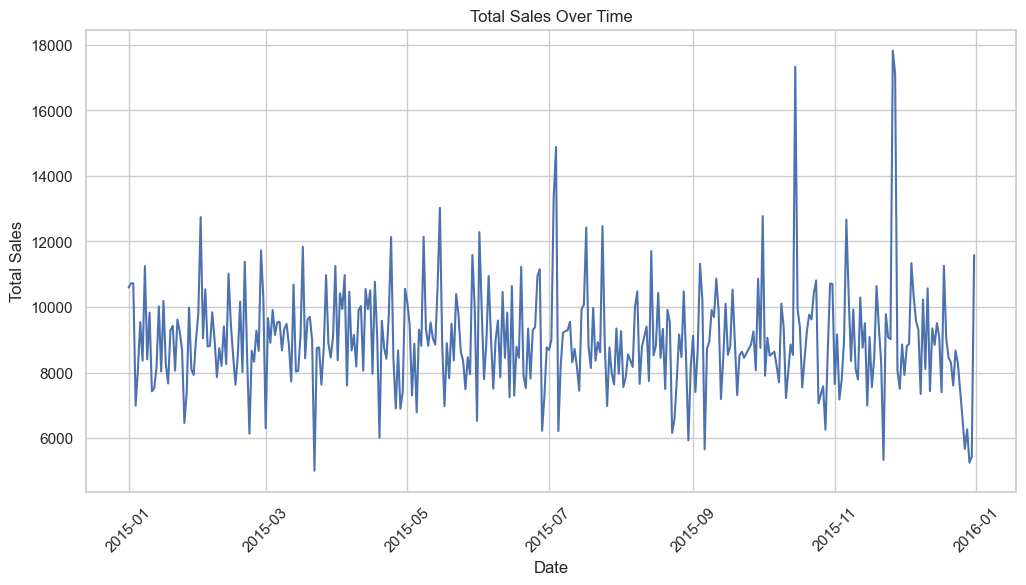

In [167]:
# Ploting sales over time
sales_over_time = merged_data.groupby('order_date')['total_price'].sum().reset_index()

plt.figure(figsize=(12,6))
sns.lineplot(data=sales_over_time, x='order_date', y='total_price')
plt.title('Total Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.show()

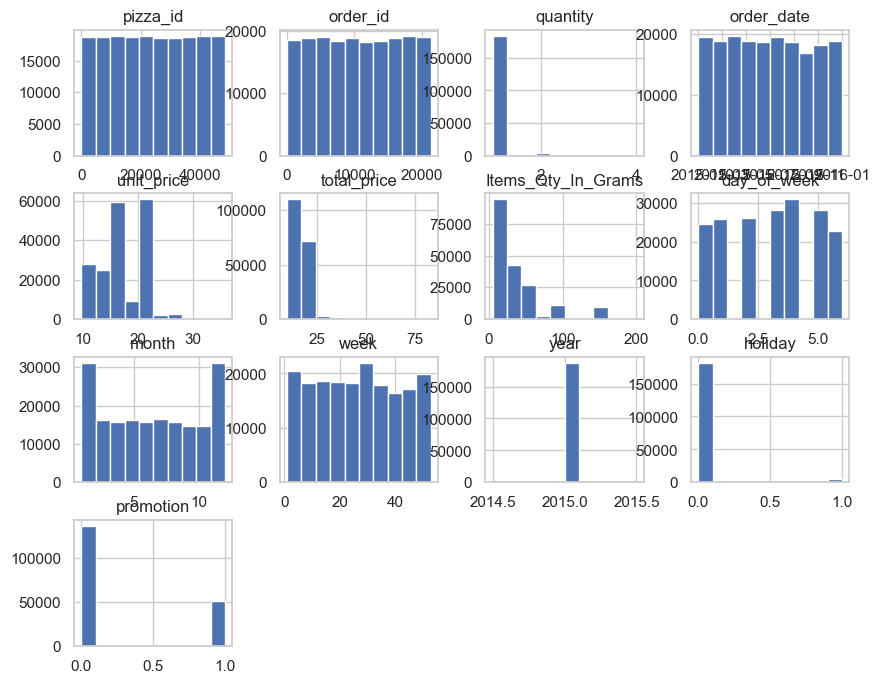

In [168]:
merged_data.hist(figsize=(10,8))
plt.show()

## Top-Selling Pizzas

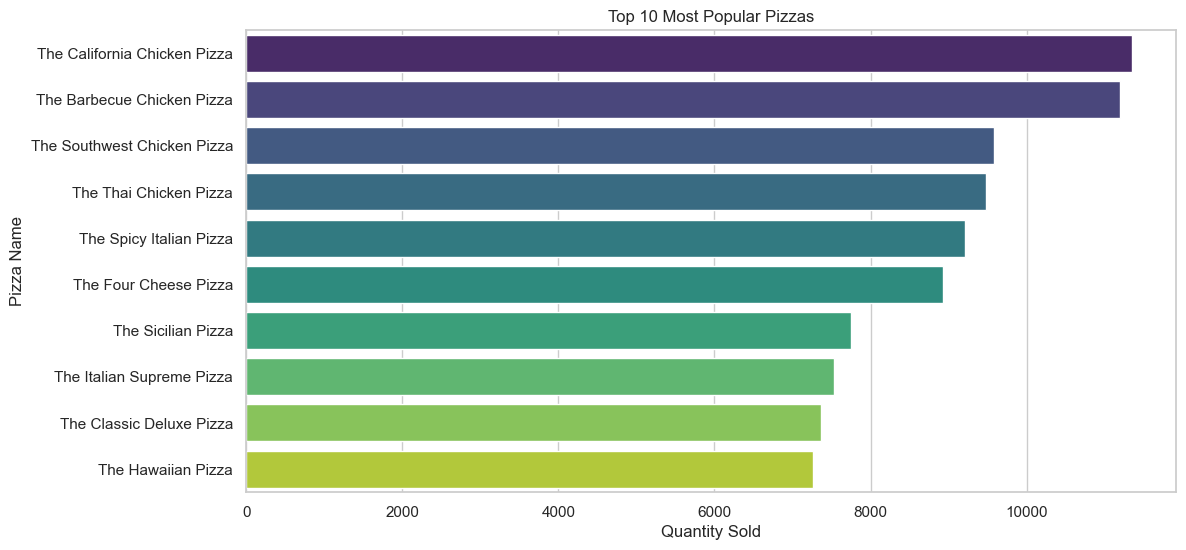

In [169]:
# Aggregate sales by pizza name
pizza_sales = merged_data.groupby('pizza_name')['quantity'].sum().reset_index()

# Sorting by quantity sold
pizza_sales = pizza_sales.sort_values(by='quantity', ascending=False)

# Ploting top 10 most popular pizzas
plt.figure(figsize=(12,6))
sns.barplot(data=pizza_sales.head(10), x='quantity', y='pizza_name', palette='viridis')
plt.title('Top 10 Most Popular Pizzas')
plt.xlabel('Quantity Sold')
plt.ylabel('Pizza Name')
plt.show()

## Sales by Pizza Size and Category

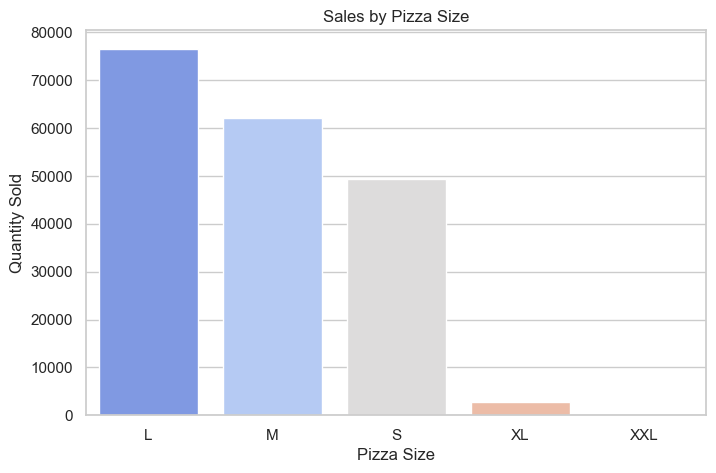

In [170]:
# Ploting pizza size distribution
size_sales = merged_data.groupby('pizza_size')['quantity'].sum().reset_index()

plt.figure(figsize=(8,5))
sns.barplot(data=size_sales, x='pizza_size', y='quantity', palette='coolwarm')
plt.title('Sales by Pizza Size')
plt.xlabel('Pizza Size')
plt.ylabel('Quantity Sold')
plt.show()

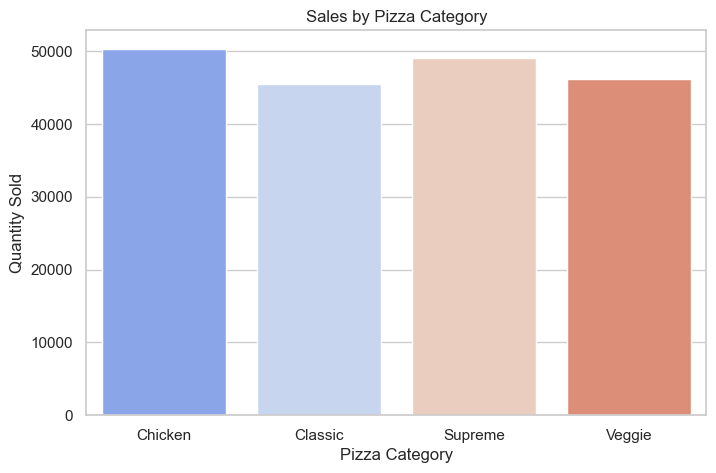

In [171]:
# Ploting pizza category distribution
category_sales = merged_data.groupby('pizza_category')['quantity'].sum().reset_index()

plt.figure(figsize=(8,5))
sns.barplot(data=category_sales, x='pizza_category', y='quantity', palette='coolwarm')
plt.title('Sales by Pizza Category')
plt.xlabel('Pizza Category')
plt.ylabel('Quantity Sold')
plt.show()

## Seasonal Sales Trends and Patterns

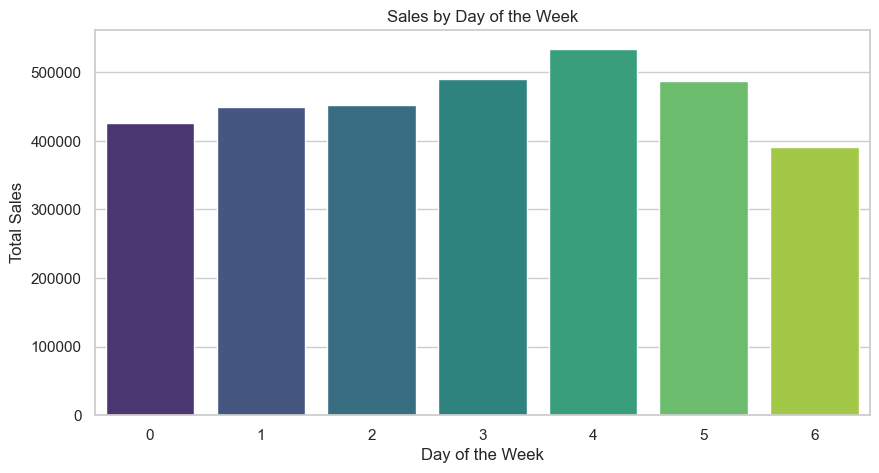

In [172]:
# Aggregate sales by day of the week
sales_by_day = merged_data.groupby('day_of_week')['total_price'].sum().reset_index()

# Order days of the week
#days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
days_order = [0, 1, 2, 3, 4, 5, 6]
sales_by_day['day_of_week'] = pd.Categorical(sales_by_day['day_of_week'], categories=days_order, ordered=True)

# Plot sales by day of the week
plt.figure(figsize=(10,5))
sns.barplot(data=sales_by_day, x='day_of_week', y='total_price', palette='viridis')
plt.title('Sales by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Total Sales')
plt.show()

## Sales by Month

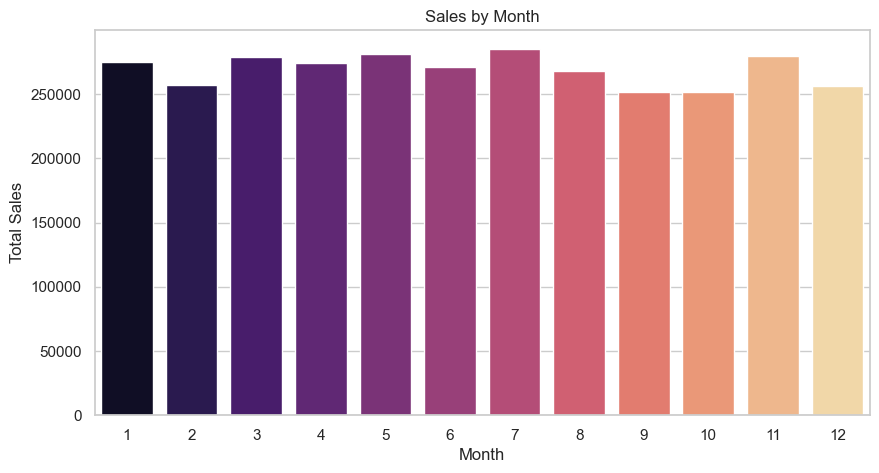

In [173]:
# Aggregate sales by month
sales_by_month = merged_data.groupby('month')['total_price'].sum().reset_index()

# Plot sales by month
plt.figure(figsize=(10,5))
sns.barplot(data=sales_by_month, x='month', y='total_price', palette='magma')
plt.title('Sales by Month')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.show()

## Correlation Analysis of Sales Metrics

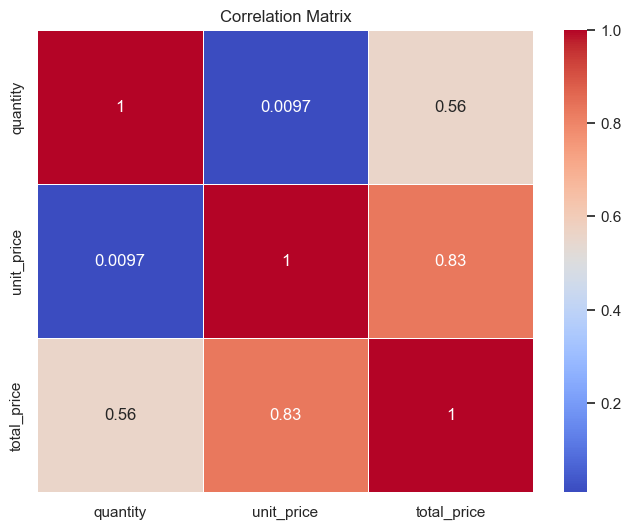

In [174]:
# Correlation matrix
corr_matrix = merged_data[['quantity', 'unit_price', 'total_price']].corr()

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

## Outlier Detection in Sales Data

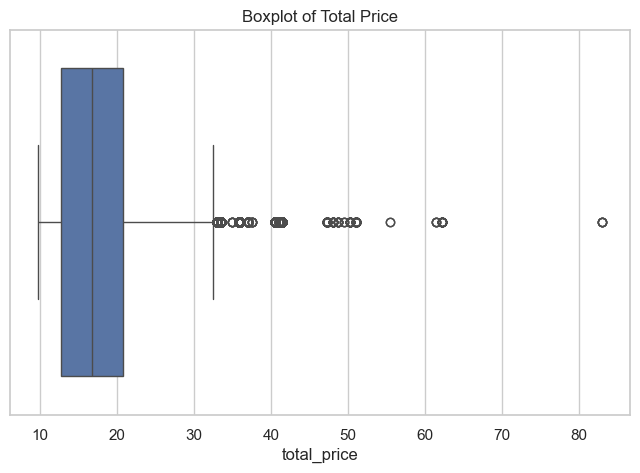

In [175]:
# Boxplot for total_price
plt.figure(figsize=(8,5))
sns.boxplot(data=merged_data, x='total_price')
plt.title('Boxplot of Total Price')
plt.show()

## Sales during holidays vs non-holidays

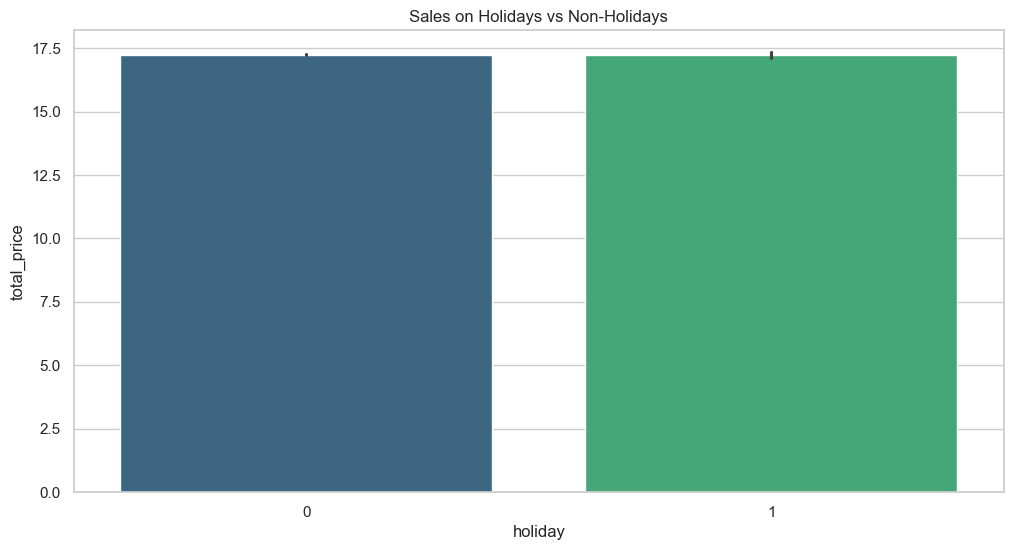

In [176]:
sns.barplot(x='holiday', y='total_price', data=merged_data, palette='viridis')
plt.title('Sales on Holidays vs Non-Holidays')
plt.show()

## Sales during promotions vs non-promotions

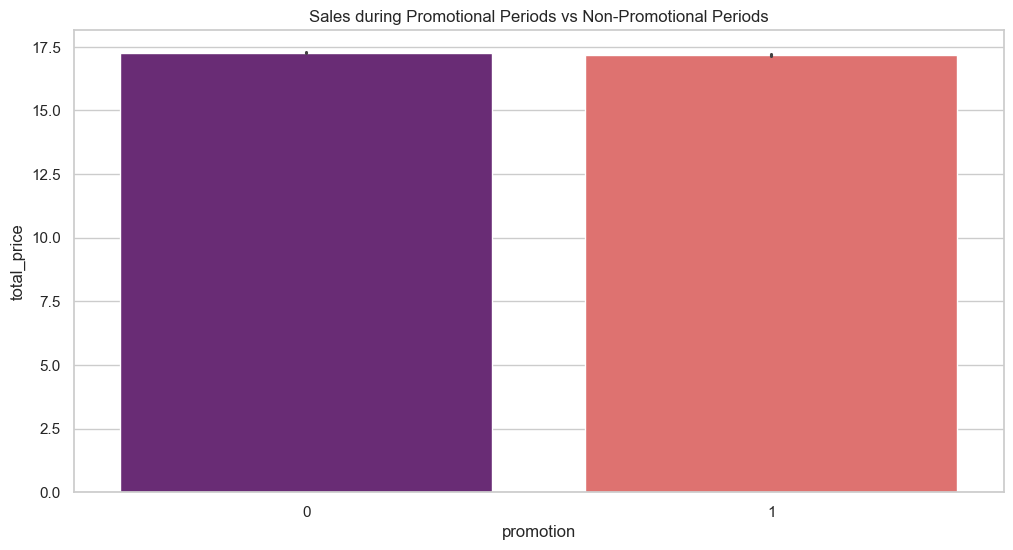

In [177]:
sns.barplot(x='promotion', y='total_price', data=merged_data, palette='magma')
plt.title('Sales during Promotional Periods vs Non-Promotional Periods')
plt.show()

# 8. Model Selection

ARIMA / SARIMA
ARIMA (AutoRegressive Integrated Moving Average) and SARIMA (Seasonal ARIMA) are great starting points if your data shows seasonal patterns and trends.

In [178]:
pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


In [179]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


# ARIMA Model
* p (AutoRegressive term): The number of past observations (lags) used to predict the future value.
* d (Differencing term): The number of times the data is differenced to make it stationary.
* q (Moving Average term): The number of past forecast errors used to improve future predictions.

In [180]:
# weekly total quantity (start of week index)
weekly_qty = merged.groupby(merged["order_date"].dt.to_period("W").apply(lambda r: r.start_time))["quantity"].sum().sort_index()
train_size = int(0.8 * len(weekly_qty))
wk_train, wk_test = weekly_qty.iloc[:train_size], weekly_qty.iloc[train_size:]


ARIMA best order: (0, 1, 1) metrics: {'MAPE': 0.1946, 'RMSE': 716.42, 'MAE': 520.73}


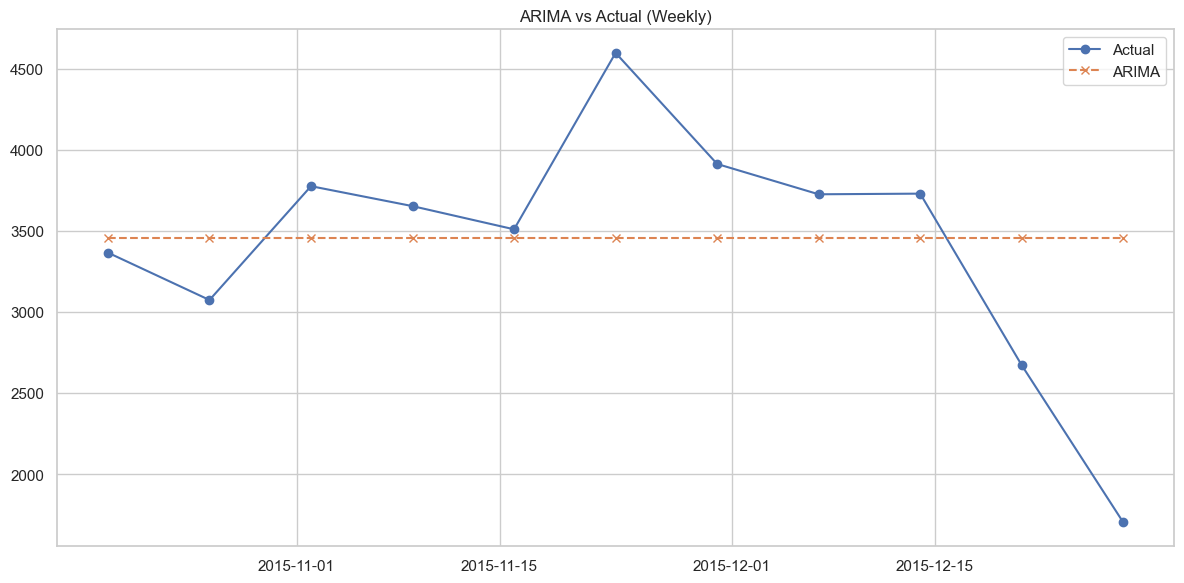

In [181]:
def tune_arima(train, test, p_range=range(0,4), d_range=range(0,2), q_range=range(0,4)):
    best = {"aic": np.inf, "order": None, "pred": None}
    for p,d,q in itertools.product(p_range, d_range, q_range):
        try:
            model = ARIMA(train, order=(p,d,q)).fit()
            pred = model.forecast(steps=len(test))
            if model.aic < best["aic"]:
                best = {"aic": model.aic, "order": (p,d,q), "pred": pred}
        except Exception:
            continue
    return best

arima_best = tune_arima(wk_train, wk_test)
arima_pred = pd.Series(arima_best["pred"].values, index=wk_test.index)
arima_metrics = eval_all(wk_test.values, arima_pred.values)
print("ARIMA best order:", arima_best["order"], "metrics:", arima_metrics)

plt.figure()
plt.plot(wk_test.index, wk_test.values, label="Actual", marker="o")
plt.plot(arima_pred.index, arima_pred.values, label="ARIMA", linestyle="--", marker="x")
plt.title("ARIMA vs Actual (Weekly)"); plt.legend(); plt.tight_layout(); plt.show()


SARIMA metrics: {'MAPE': 0.1849, 'RMSE': 704.69, 'MAE': 585.84}


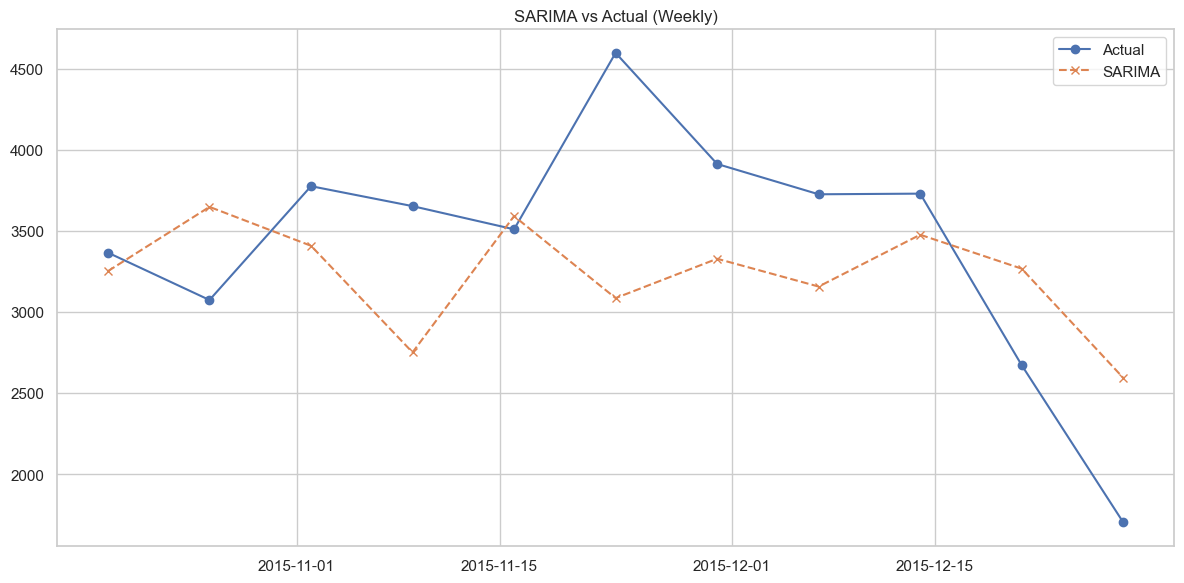

In [182]:
def fit_sarima(train, test, order=(1,1,1), seasonal=(1,1,1,7)):
    model = SARIMAX(train, order=order, seasonal_order=seasonal).fit(disp=False)
    pred = model.forecast(steps=len(test))
    return model, pd.Series(pred.values, index=test.index)

sarima_model, sarima_pred = fit_sarima(wk_train, wk_test)
sarima_metrics = eval_all(wk_test.values, sarima_pred.values)
print("SARIMA metrics:", sarima_metrics)

plt.figure()
plt.plot(wk_test.index, wk_test.values, label="Actual", marker="o")
plt.plot(sarima_pred.index, sarima_pred.values, label="SARIMA", linestyle="--", marker="x")
plt.title("SARIMA vs Actual (Weekly)"); plt.legend(); plt.tight_layout(); plt.show()





14:26:42 - cmdstanpy - INFO - Chain [1] start processing
14:26:42 - cmdstanpy - INFO - Chain [1] done processing


Prophet metrics: {'MAPE': 5.3907, 'RMSE': 25467.48, 'MAE': 19952.74}


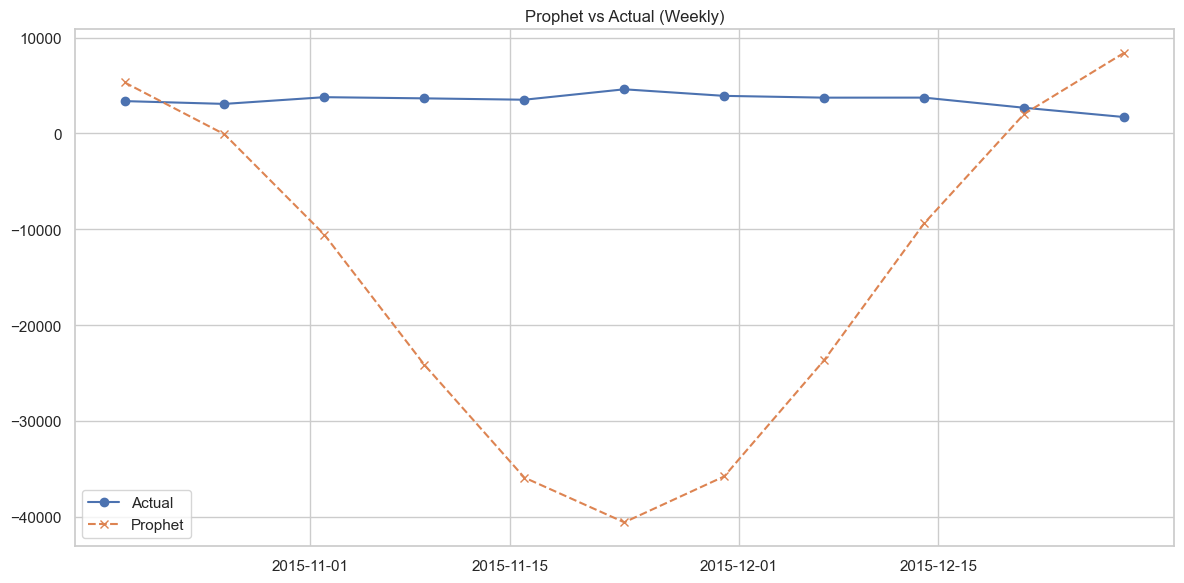

In [183]:
if HAS_PROPHET:
    def make_prophet_df(series):
        return pd.DataFrame({"ds": series.index, "y": series.values})

    pr_train = make_prophet_df(wk_train)
    pr_test  = make_prophet_df(wk_test)

    pr = Prophet(weekly_seasonality=True, yearly_seasonality=True, daily_seasonality=False)
    pr.fit(pr_train)

    future = pr.make_future_dataframe(periods=len(wk_test), freq="W")
    fcst   = pr.predict(future)
    pr_pred = pd.Series(fcst["yhat"].iloc[-len(wk_test):].values, index=wk_test.index)
    prophet_metrics = eval_all(wk_test.values, pr_pred.values)
    print("Prophet metrics:", prophet_metrics)

    plt.figure()
    plt.plot(wk_test.index, wk_test.values, label="Actual", marker="o")
    plt.plot(pr_pred.index, pr_pred.values, label="Prophet", linestyle="--", marker="x")
    plt.title("Prophet vs Actual (Weekly)"); plt.legend(); plt.tight_layout(); plt.show()
else:
    prophet_metrics = {"MAPE": np.nan, "RMSE": np.nan, "MAE": np.nan}
    print("Prophet not installed — skipping.")


Regression metrics:

 {'MAPE': 0.1911, 'RMSE': 710.64, 'MAE': 501.66}


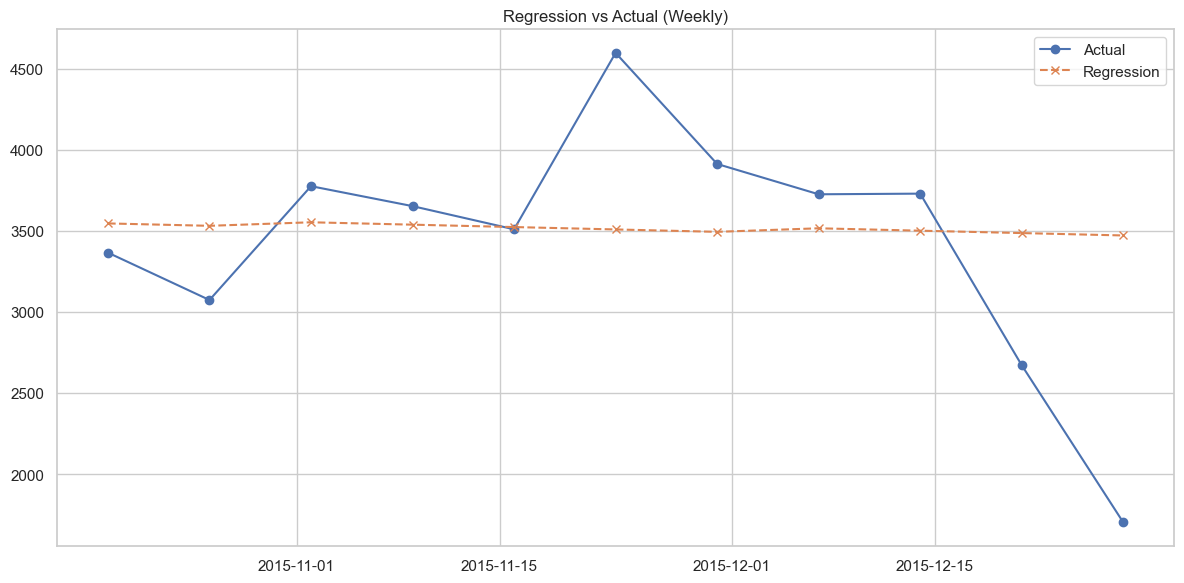

In [184]:
def add_calendar(df_index):
    df = pd.DataFrame({"ds": df_index})
    df["weekofyear"] = df["ds"].dt.isocalendar().week.astype(int)
    df["month"]      = df["ds"].dt.month
    df["year"]       = df["ds"].dt.year
    return df

Xtr = add_calendar(wk_train.index)
Xte = add_calendar(wk_test.index)
ytr = wk_train.values
yte = wk_test.values

lr = LinearRegression().fit(Xtr[["weekofyear","month","year"]], ytr)
lr_pred = lr.predict(Xte[["weekofyear","month","year"]])
reg_metrics = eval_all(yte, lr_pred)
print("Regression metrics:", reg_metrics)

plt.figure()
plt.plot(wk_test.index, wk_test.values, label="Actual", marker="o")
plt.plot(wk_test.index, lr_pred, label="Regression", linestyle="--", marker="x")
plt.title("Regression vs Actual (Weekly)"); plt.legend(); plt.tight_layout(); plt.show()


        Model    MAPE      RMSE       MAE  Rank
0      SARIMA  0.1849    704.69    585.84   1.0
1  Regression  0.1911    710.64    501.66   2.0
2       ARIMA  0.1946    716.42    520.73   3.0
3     Prophet  5.3907  25467.48  19952.74   4.0


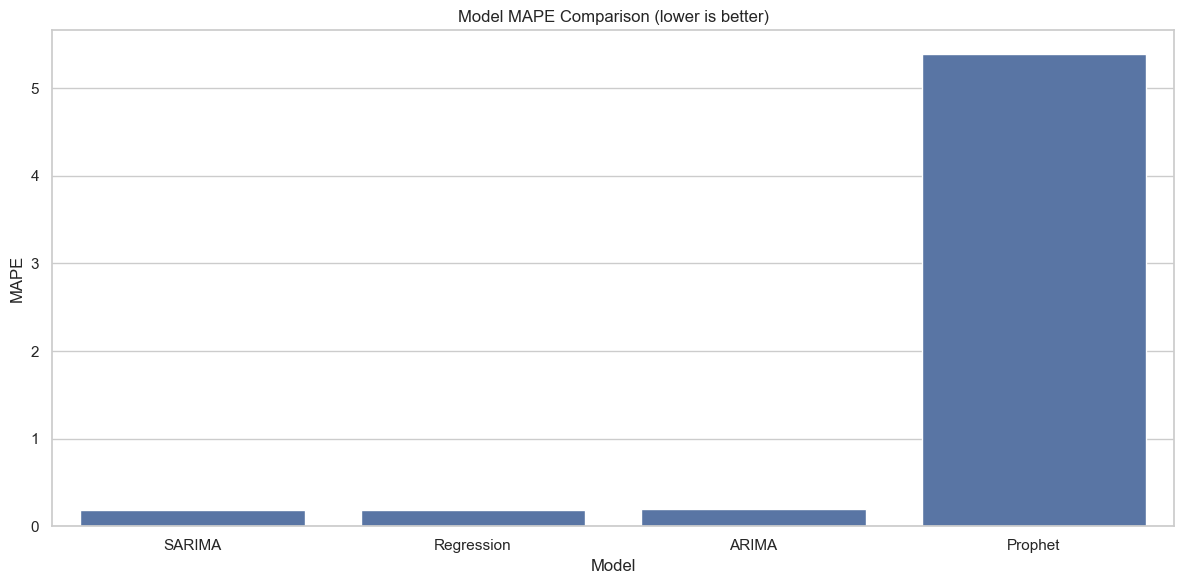

In [185]:
results = pd.DataFrame({
    "Model":      ["SARIMA","ARIMA","Prophet","Regression"],
    "MAPE":       [sarima_metrics["MAPE"], arima_metrics["MAPE"], prophet_metrics["MAPE"], reg_metrics["MAPE"]],
    "RMSE":       [sarima_metrics["RMSE"], arima_metrics["RMSE"], prophet_metrics["RMSE"], reg_metrics["RMSE"]],
    "MAE":        [sarima_metrics["MAE"],  arima_metrics["MAE"],  prophet_metrics["MAE"],  reg_metrics["MAE"]],
})
results = results.sort_values("MAPE", na_position="last").reset_index(drop=True)
results["Rank"] = results["MAPE"].rank(method="min")
print(results)

plt.figure()
sns.barplot(data=results, x="Model", y="MAPE")
plt.title("Model MAPE Comparison (lower is better)"); plt.tight_layout(); plt.show()


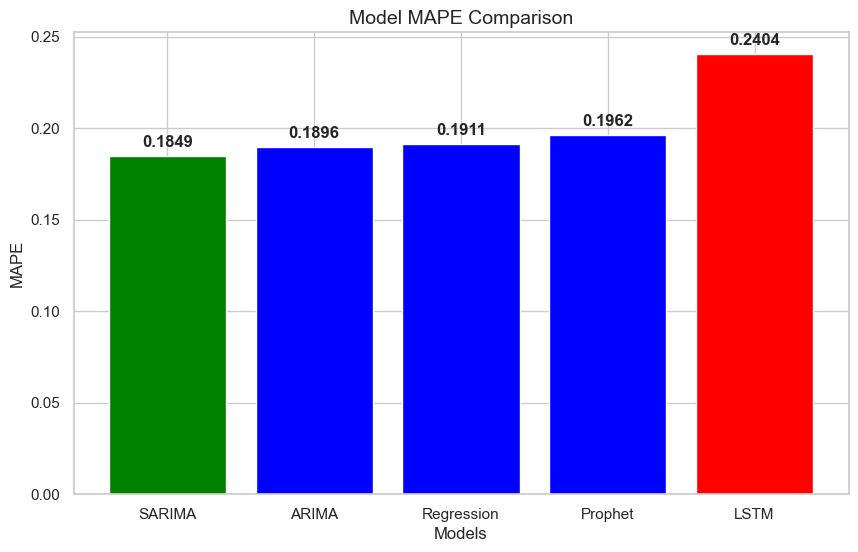

In [187]:
import matplotlib.pyplot as plt

# Data for plotting
models = ['SARIMA', 'ARIMA', 'Regression', 'Prophet', 'LSTM']
mapes = [0.1849, 0.1896, 0.1911, 0.1962, 0.2404]

plt.figure(figsize=(10,6))
plt.bar(models, mapes, color=['green', 'blue', 'blue', 'blue', 'red'])

# Highlighting the best and worst models
plt.title('Model MAPE Comparison', fontsize=14)
plt.xlabel('Models', fontsize=12)
plt.ylabel('MAPE', fontsize=12)

for i, v in enumerate(mapes):
    plt.text(i, v + 0.005, f'{v:.4f}', ha='center', fontweight='bold')

plt.show()

## SARIMA Evaluation

## Hyperparameter Tuning for SARIMA

In [196]:
# Useing auto_arima to find the best parameters
auto_model = auto_arima(train, seasonal=True, m=7, trace=True, error_action='ignore', suppress_warnings=True)
print(auto_model.summary())

NameError: name 'auto_arima' is not defined

## Saving the Model Using pickle

In [207]:
import pickle

# Save the trained SARIMA model
with open('best_sarima_model.pkl', 'wb') as file:
    pickle.dump(sarima_model, file)

print("✅ SARIMA model saved successfully!")


✅ SARIMA model saved successfully!


In [208]:
# Load the saved SARIMA model
with open('best_sarima_model.pkl', 'rb') as file:
    loaded_sarima_model = pickle.load(file)

print("✅ SARIMA model loaded successfully!")


✅ SARIMA model loaded successfully!


# 10. Final Results and Predictions

In [209]:
# Loading the model
model_filename = 'best_sarima_model.pkl'
with open(model_filename, 'rb') as file:
    loaded_model = pickle.load(file)

# Forecasting function
def forecast_sales(loaded_model, periods):
    forecast = loaded_model.predict(n_periods=periods)
    return forecast

forecasted_sales = forecast_sales(loaded_model, periods=7)
print(forecasted_sales)

2014-12-29       0.000000
2015-01-05    2123.960952
2015-01-12    3599.436006
2015-01-19    3588.004559
2015-01-26    3644.083516
2015-02-02    3763.558243
2015-02-09    3828.489832
2015-02-16    4920.805329
2015-02-23    5212.701482
2015-03-02    4467.725518
2015-03-09    4138.336074
2015-03-16    4101.689654
2015-03-23    3950.017805
2015-03-30    3780.274316
2015-04-06    3404.945219
2015-04-13    4119.720236
2015-04-20    4144.850427
2015-04-27    3915.206130
2015-05-04    3835.182402
2015-05-11    3754.238162
2015-05-18    3987.600503
2015-05-25    3727.918373
2015-06-01    3808.636623
2015-06-08    3792.750411
2015-06-15    3688.648670
2015-06-22    3753.188586
2015-06-29    3871.566106
2015-07-06    3802.980471
2015-07-13    3642.742923
2015-07-20    3897.242059
2015-07-27    3837.016067
2015-08-03    3611.795459
2015-08-10    3690.952321
2015-08-17    3956.625853
2015-08-24    3651.942556
2015-08-31    3542.392126
2015-09-07    3561.942641
2015-09-14    3432.230093
2015-09-21  

## Forecasting Report Visulazation

In [214]:
with open('best_sarima_model.pkl', 'rb') as file:
    best_model = pickle.load(file)


In [219]:
# Forecast for next 7 days (weekly model assumes total week forecast)
n_forecast = 1  # since model is weekly
forecast = best_model.forecast(steps=n_forecast)  # forecast is a pandas Series

# Prepare forecast DataFrame
last_week_date = wk_train.index[-1]  # your training data index
next_week_start = last_week_date + pd.Timedelta(weeks=1)
next_week_end = next_week_start + pd.Timedelta(days=6)

forecast_df = pd.DataFrame({
    'week_start': [next_week_start],
    'week_end': [next_week_end],
    'forecast_sales': [forecast.values[0]]
})

print("📈 Forecasted total pizza sales for next week:")
print(forecast_df)


📈 Forecasted total pizza sales for next week:
  week_start   week_end  forecast_sales
0 2015-10-19 2015-10-25     3251.125557


In [223]:
# Forecast for next week (weekly model)
n_forecast = 1  # since model is weekly
forecast = best_model.forecast(steps=n_forecast)  # returns pandas Series

# Prepare forecast DataFrame
last_week_date = wk_train.index[-1]  # index from your training data
next_week_start = last_week_date + pd.Timedelta(weeks=1)
next_week_end = next_week_start + pd.Timedelta(days=6)

forecast_df = pd.DataFrame({
    'week_start': [next_week_start],
    'week_end': [next_week_end],
    'forecast_sales': [forecast.values[0]]
})

print("📈 Forecasted total pizza sales for next week:")
print(forecast_df)


📈 Forecasted total pizza sales for next week:
  week_start   week_end  forecast_sales
0 2015-10-19 2015-10-25     3251.125557


In [224]:
# Calculate historical proportion of each pizza type
pizza_proportion = pizza_sales.groupby('pizza_name')['quantity'].sum() / pizza_sales['quantity'].sum()

# Forecast per pizza type
forecast_df_pizza = pd.DataFrame({
    'pizza_name': pizza_proportion.index,
    'forecast_sales': pizza_proportion.values * forecast.values[0]
})

print("📊 Forecasted pizza sales per type for next week:")
print(forecast_df_pizza)


📊 Forecasted pizza sales per type for next week:
                                    pizza_name  forecast_sales
0                   The Barbecue Chicken Pizza      190.526693
1                           The Big Meat Pizza       97.748773
2                         The Brie Carre Pizza       33.366004
3                          The Calabrese Pizza       63.803971
4                 The California Chicken Pizza      193.216401
5                    The Chicken Alfredo Pizza       82.376578
6                      The Chicken Pesto Pizza       66.255351
7                     The Classic Deluxe Pizza      125.275727
8                        The Five Cheese Pizza       47.972143
9                        The Four Cheese Pizza      151.917459
10                             The Greek Pizza      110.924940
11                      The Green Garden Pizza       69.506834
12                          The Hawaiian Pizza      123.692544
13                 The Italian Capocollo Pizza       97.919008
14    

In [229]:
print(Ingr.columns)


Index(['pizza_name_id', 'pizza_name', 'pizza_ingredients',
       'Items_Qty_In_Grams'],
      dtype='object')


In [232]:
# Merge forecasted sales with ingredients dataset
ingredient_demand = Ingr.merge(forecast_df_pizza, on='pizza_name', how='left')

# Calculate total ingredient required for the week
ingredient_demand['total_ingredient_required'] = ingredient_demand['forecast_sales'] * ingredient_demand['Items_Qty_In_Grams']

# Aggregate by ingredient
total_ingredients = ingredient_demand.groupby('pizza_ingredients')['total_ingredient_required'].sum().reset_index()

print("📦 Ingredient requirements for the upcoming week:")
print(total_ingredients)



📦 Ingredient requirements for the upcoming week:
          pizza_ingredients  total_ingredient_required
0              ?duja Salami                7656.476526
1             Alfredo Sauce                3706.946029
2                 Anchovies                8473.603157
3                Artichokes               27876.785698
4                   Arugula                1710.348178
..                      ...                        ...
59       Sun-dried Tomatoes                4012.602459
60  Thai Sweet Chilli Sauce                9687.036203
61                    Thyme                 166.830020
62                 Tomatoes              128861.891012
63                 Zucchini               11015.888385

[64 rows x 2 columns]


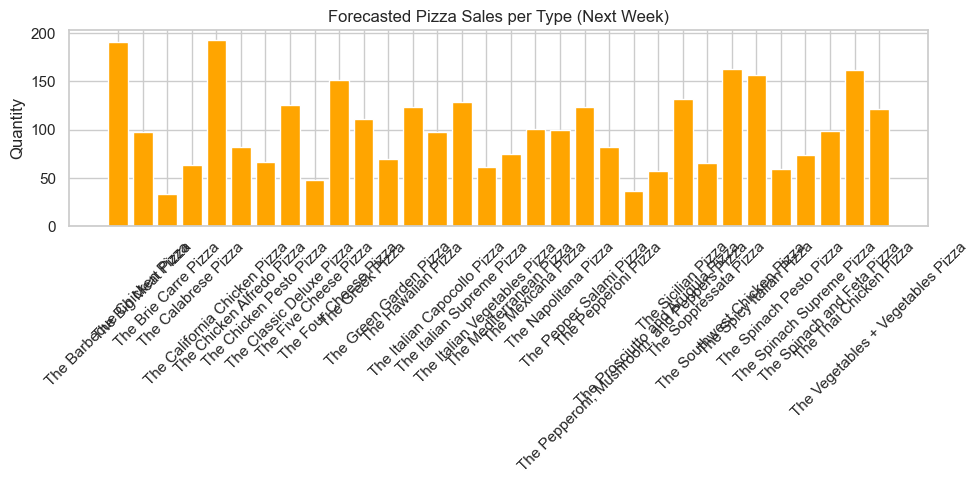

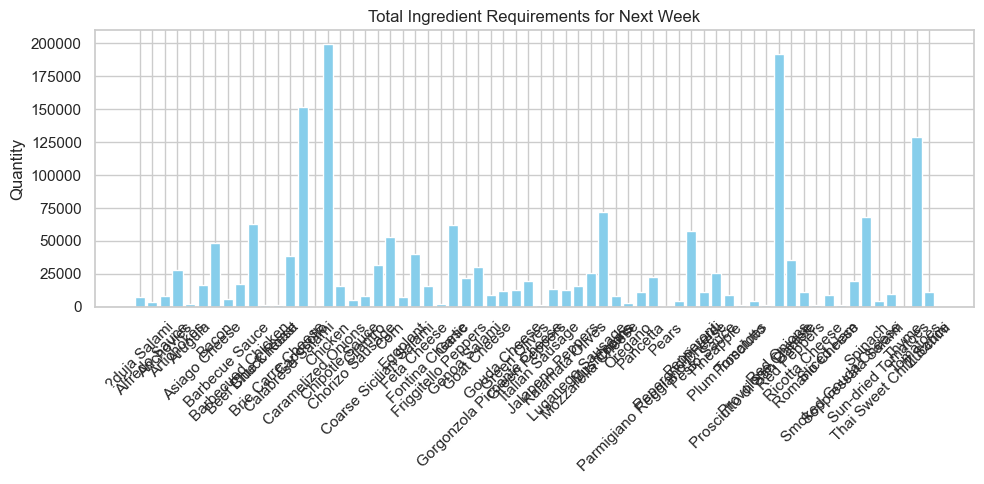

In [234]:
# Forecasted pizza sales per type
plt.figure(figsize=(10,5))
plt.bar(forecast_df_pizza['pizza_name'], forecast_df_pizza['forecast_sales'], color='orange')
plt.title('Forecasted Pizza Sales per Type (Next Week)')
plt.ylabel('Quantity')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Total ingredient requirements
plt.figure(figsize=(10,5))
plt.bar(total_ingredients['pizza_ingredients'], total_ingredients['total_ingredient_required'], color='skyblue')
plt.title('Total Ingredient Requirements for Next Week')
plt.ylabel('Quantity')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
